In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

Read in the data and scale pixel values from [0,255] to [0,1].

(42000, 784)
(28000, 784)


<AxesSubplot:ylabel='count'>

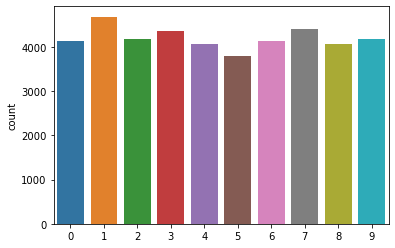

In [5]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
X_train = train.iloc[:,1:].values/255 
y_train = train.iloc[:,0].values
X_test = test.values/255
print(X_train.shape)
print(X_test.shape)
sn.countplot(x = y_train)


Plot some sample images from the data (train and test).

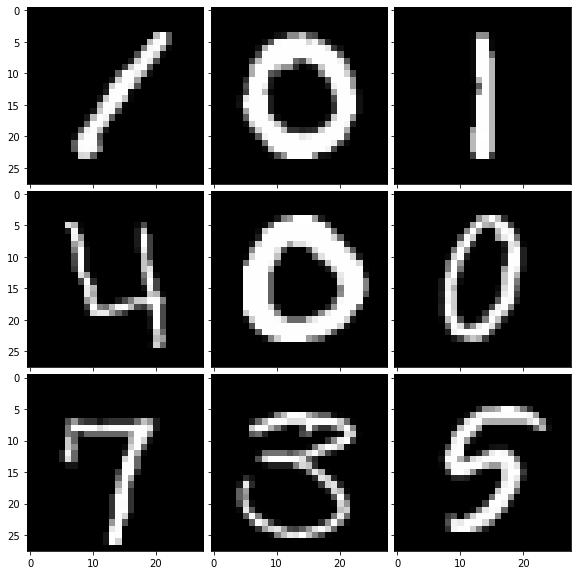

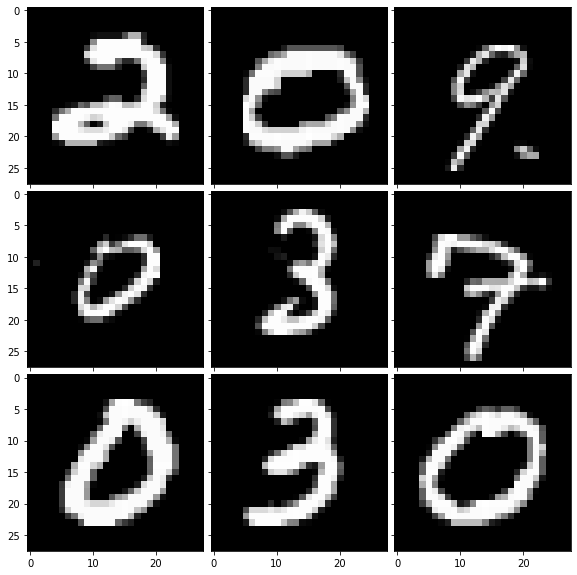

In [6]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(len(grid)):
    grid[i].imshow(X_train[i].reshape(28,28), cmap = 'gray')
    
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(len(grid)):
    grid[i].imshow(X_test[i].reshape(28,28), cmap = 'gray')

Reshape to matrices since we will be using a CNN.

In [13]:
X_train = np.array([img.reshape(28,28) for img in X_train])
X_test = np.array([img.reshape(28,28) for img in X_test])

We will do some data augmentation in the hopes this will help the model classify more difficult examples, in particular due to orientation. Since there is generally some level of padding on these images, adding some small random rotations should work well as we can safely just pad the edges with black pixels. We will only consider small rotations as all digits are recorded in the correct orientation, so any rotational differences will be small. In particular we do not need to anticipate for example an upsided down digit being classified. We will construct augmented datasets for rotations of (degrees): $\pm 10,\pm20$

In [14]:
import math
'''
Function borrowed from elsewhere. I think there is some kind of smoothing done to deal with missing pixels, see eg. below with the 5th train image. 
*** Look into this ***
'''
def rotate(img, degrees):
    tmp = np.zeros((40,40))
    tmp[6:34, 6:34] = img
    tmp = tmp.reshape(1600,)
    i = list(range(6,34))*28
    j = np.array(sorted(i)).astype(int)
    i = np.array(i).astype(int)
    a = math.radians(degrees)
    i_rotated = (i-20.5)*np.cos(a) + (j-20.5)*np.sin(a) + 20.5
    j_rotated = -(i-20.5)*np.sin(a) + (j-20.5)*np.cos(a) + 20.5
    i0 = np.floor(i_rotated).astype(int)
    i1 = np.ceil(i_rotated).astype(int)
    lambda_i = i_rotated-i0
    j0 = np.floor(j_rotated)
    j1 = np.ceil(j_rotated)
    lambda_j = j_rotated-j0
    rotated = tmp[(i0+j0*40).astype(int)] * (1-lambda_i) * (1-lambda_j) + tmp[(i0+j1*40).astype(int)] * (1-lambda_i) * lambda_j + tmp[(i1+j0*40).astype(int)] * lambda_i * (1-lambda_j) + tmp[(i1+j1*40).astype(int)] * lambda_i * lambda_j
    return(rotated.reshape(28,28))
    

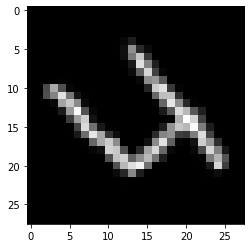

In [17]:
'''
Possibly do something to combat smoothing?
'''
plt.imshow(rotate(X_train[3], -30), cmap = "gray")

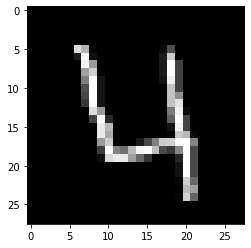

In [19]:
plt.imshow(X_train[3], cmap = "gray")

In [20]:
X_train_10a = np.array([rotate(img,10) for img in X_train])
y_train_10a = y_train
X_train_10b = np.array([rotate(img,-10) for img in X_train])
y_train_10b = y_train
X_train_20a = np.array([rotate(img,20) for img in X_train])
y_train_20a = y_train
X_train_20b = np.array([rotate(img,-20) for img in X_train])
y_train_20b = y_train

In [21]:
X_train_aug = np.concatenate((X_train, X_train_10a, X_train_10b, X_train_20a, X_train_20b))
y_train_aug = np.concatenate((y_train, y_train_10a, y_train_10b, y_train_20a, y_train_20b))

In [22]:
# X needs to have an extra dimension
X_train_aug = X_train_aug.reshape(210000,28,28,1)

In [23]:
# y needs to be one hot encoded
temp = np.zeros((y_train_aug.size, y_train_aug.max()+1))
temp[np.arange(y_train_aug.size),y_train_aug] = 1
y_train_aug = temp

Now start building a CNN.

In [24]:
l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')
l4 = tf.keras.layers.Dropout(rate = 0.4)
l5 = tf.keras.layers.Flatten()
l6 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model = tf.keras.Sequential([l1,l2,l3,l4,l5,l6])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])
model.fit(X_train_aug, y_train_aug, epochs = 20, batch_size = 128)

Epoch 1/20
1641/1641 [==============================] - 13s 5ms/step - loss: 0.3169 - acc: 0.9014
Epoch 2/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0800 - acc: 0.9751
Epoch 3/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0609 - acc: 0.9811
Epoch 4/20
1641/1641 [==============================] - 9s 5ms/step - loss: 0.0474 - acc: 0.9849
Epoch 5/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0427 - acc: 0.9862
Epoch 6/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0368 - acc: 0.9876
Epoch 7/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0335 - acc: 0.9892
Epoch 8/20
1641/1641 [==============================] - 9s 5ms/step - loss: 0.0299 - acc: 0.9900
Epoch 9/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0275 - acc: 0.9908
Epoch 10/20
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0250 - acc: 0.9917
Epoch 11/20
1641/1641 [=====

Look into which images are being misclassified. We find all misclassified image then plot the first 16 and last 16 and compare true vs predictions. The reason for this choice is to see misclassified samples from the original data and our augmented additions.

In [ ]:
y_labels = np.argmax(y_train_aug, axis = 1)
train_predictions = np.argmax(model.predict(X_train_aug), axis = 1)
misclassified = [i for i in range(len(y_labels)) if y_labels[i] != train_predictions[i]]

In [ ]:
'''
plt.subplot with plt.imshow will remove need for ImageGrid and allow for plot title 
'''

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in misclassified[0:len(grid)]:
    print("Predicted: " + str(train_predictions[i]) + ", True: " + str(y_labels[i]))

for ax, i in zip(grid, misclassified[0:len(grid)]):
    ax.imshow(X_train_aug[i].reshape(28,28), cmap = 'gray')

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in misclassified[-len(grid):]:
    print("Predicted: " + str(train_predictions[i]) + ", True: " + str(y_labels[i]))

for ax, i in zip(grid, misclassified[-len(grid):]):
    ax.imshow(X_train_aug[i].reshape(28,28), cmap = 'gray')

The majority of these misclassifications seem quite reasonable, in particular we can clearly understand why the particular wrong label was assigned. We have 9 and 4 commonly mixed up, 1 which are quite wide misclassified as 8, 7 and 9 mixed up when the opening on the 9 is not clear. Many of these examples could not even be classified with a lot of confidence by eye. As a result I'm not really sure what can be done to overcome these misclassifications, and more importantly correctly classify similar examples in the test set.

Produce the test predictions submission file.

In [ ]:
# probas = model.predict(X_test.reshape((len(X_test),28,28,1)))
# pred = [np.argmax(prob) for prob in probas]
# pred = pd.DataFrame({'ImageID': list(range(1,len(pred)+1)), 'Label': pred})
# pred.set_index('ImageID', inplace = True)
# pred.to_csv('submission_aug.csv')

Test Accuracy Achieved with the above model: 0.98832

Check if the data augmentation is making any improvement by using the same architecture with just the original data.

In [ ]:
X_train = X_train.reshape(42000,28,28,1)
temp = np.zeros((y_train.size, y_train.max()+1))
temp[np.arange(y_train.size),y_train] = 1
y_train = temp

l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')
l4 = tf.keras.layers.Dropout(rate = 0.4)
l5 = tf.keras.layers.Flatten()
l6 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model = tf.keras.Sequential([l1,l2,l3,l4,l5,l6])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])
model.fit(X_train, y_train, epochs = 40, batch_size = 128) # we can afford more epochs with less data

# probas = model.predict(X_test.reshape((len(X_test),28,28,1)))
# pred = [np.argmax(prob) for prob in probas]
# pred = pd.DataFrame({'ImageID': list(range(1,len(pred)+1)), 'Label': pred})
# pred.set_index('ImageID', inplace = True)
# pred.to_csv('submission.csv')

Test Accuracy Achieved: 0.98557

Up to this point working with the augmented dataset has showed accuracy improvement of 0.00275 or 0.275%. However note that training duration has not yet been varied to test how generic this improvement is. It may be worth noting that the unaugmented model had higher training accuracy, so it seems the augmentations help to achieve the specified goal of improving generalisation performance. The augmented data model had 0.43% lower training accuracy despite eventually achieving 0.275% higher test accuracy.

**Next:**
* Do more exploration and intro work (class imbalance etc.)
* Vary the CNN architecture, vary complexity, layer sizes, dropout or not etc.
* Incorporate Validation instead of just train, test
* Finetuning: Vary layers, filters, training parameters, learning rate
* Other Methods: Try classical methods like knn, trees possibly combined with PCA


In [ ]:
l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l4 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')
l5 = tf.keras.layers.Dropout(rate = 0.4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l7 = tf.keras.layers.Flatten()
l8 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model = tf.keras.Sequential([l1,l2,l3,l4,l5,l6,l7,l8])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])
model.fit(X_train_aug, y_train_aug, epochs = 60, batch_size = 128)

In [ ]:
model.fit(X_train_aug, y_train_aug, epochs = 20, batch_size = 128)

In [25]:
l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')
l5 = tf.keras.layers.Dropout(rate = 0.4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')
l8 = tf.keras.layers.Dropout(rate = 0.4)
l9 = tf.keras.layers.Flatten()
l10 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model = tf.keras.Sequential([l1,l2,l3,l4,l5,l6,l7,l8,l9, l10])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])
model.fit(X_train_aug, y_train_aug, epochs = 40, batch_size = 128)

Epoch 1/40
1641/1641 [==============================] - 9s 5ms/step - loss: 0.3186 - acc: 0.8961
Epoch 2/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0563 - acc: 0.9821
Epoch 3/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0434 - acc: 0.9862
Epoch 4/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0363 - acc: 0.9880
Epoch 5/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0318 - acc: 0.9896
Epoch 6/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0288 - acc: 0.9904
Epoch 7/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0264 - acc: 0.9914
Epoch 8/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0247 - acc: 0.9919
Epoch 9/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0240 - acc: 0.9920
Epoch 10/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0214 - acc: 0.9929
Epoch 11/40
1641/1641 [======

In [26]:
model.fit(X_train_aug, y_train_aug, epochs = 40, batch_size = 128)

Epoch 1/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0147 - acc: 0.9953
Epoch 2/40
1641/1641 [==============================] - 7s 5ms/step - loss: 0.0151 - acc: 0.9952
Epoch 3/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0142 - acc: 0.9953
Epoch 4/40
1641/1641 [==============================] - 7s 5ms/step - loss: 0.0142 - acc: 0.9954
Epoch 5/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0142 - acc: 0.9955
Epoch 6/40
1641/1641 [==============================] - 7s 5ms/step - loss: 0.0140 - acc: 0.9954
Epoch 7/40
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0134 - acc: 0.9958
Epoch 8/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0143 - acc: 0.9955
Epoch 9/40
1641/1641 [==============================] - 8s 5ms/step - loss: 0.0129 - acc: 0.9960
Epoch 10/40
1641/1641 [==============================] - 7s 4ms/step - loss: 0.0143 - acc: 0.9958
Epoch 11/40
1641/1641 [======

In [27]:
probas = model.predict(X_test.reshape((len(X_test),28,28,1)))
pred = [np.argmax(prob) for prob in probas]
pred = pd.DataFrame({'ImageID': list(range(1,len(pred)+1)), 'Label': pred})
pred.set_index('ImageID', inplace = True)
pred.to_csv('submission_aug.csv')

Test Accuracy Achieved: 0.99489

Our previous best model used two convolutional layers with 32 filters and no downsampling, each with dropout. This more complex still uses convolutional layers and dropout. However we now have 3 convolutional layers, and we downsample the images (28->14->7) while increasing the number of filters (32->64->128) throughout. This is the best performance so far by around 0.006 or 0.6%. It may be worth noting this model also shows the smallest difference in training vs test accuracy (around 0.1%). It seems that the incorporation of downsampling and/or more feature maps allows the model to learn more generalisable representations of the images, leading to less deterioration in performance on the test data.